# Lab 2.2: Developing a Classification Model with Titanic Dataset

For this dataset, we will try to build a model to predict whether a passanger will survive. We will use the Titanic passenger dataset to build a classification model.

**Rubric**
- 6 pts - Contains all required components and uses professional language
- 5 pts - Contains all required components, but uses unprofessional language, formating, etc.
- 4 pts - Contains some, but not all, of the required components
- 3 pts - Did not submit

## Set up your environment
For this lab you will need to imort `pandas`, `numpy`, `matplotlib.pyplot`, and `seaborn`. For some statistics tests we will use `stats` from `scipy`. We will also use

- `from sklearn.neighbors import KNeighborsClassifier`
- `from sklearn.model_selection import train_test_split`
- `from sklearn.metrics import confusion_matrix`

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from scipy import stats 


In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## Set up the dataset
Import `titanic_dataset.csv` with `.read_csv()` to set up your DataFrame. You can remove extra columns `df.drop(columns=['id','alive','class','sibsp','parch','who','adult_male','alone'])`. *We will come back to these later in the lab*.

In [4]:
df = pd.read_csv("titanic.csv")

Fun fact, this is one of the most famous datasets in the machine learning community next to the MNIST and Iris dataset!

## Data cleaning

Since this is such a popular dataset, it is well-maintained and pretty clean already. However, there are a couple things we want to do before **exploratory data analysis**.

- Handle missing or null data
- Add or remove columns
- Encode categorical data

### Handling missing values

The first thing we need to know, is if there are any missing or null values in our dataframe. Determine the number of missing values per column. Recall the functions `isnull()` and `notnull()` which indicates whether a value is null (or not null). In combination with `.sum()`, this calculation is pretty simple.

In [5]:
df.isnull()

df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Another fun way to look at the same information is to use a heatmap like this: `sns.heatmap(df.isnull(), yticklabels=False)`

<AxesSubplot: >

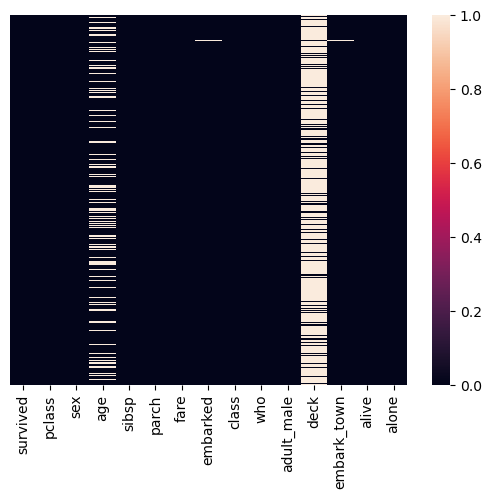

In [6]:
sns.heatmap(df.isnull(), yticklabels=False)

So there are null values in 4 columns:

- Age
- Embarked
- Deck
- Embark_town

We can take care of these in a couple different ways:
1. Drop data
    1. Drop the whole row
    2. Drop the whole column
2. Replace data
    1. Replace it by mean
    2. Replace it by frequency
    3. Replace it based on other functions
  
How do you think we should replace this data?

- Replace it by frquency
- Drop the whole row 
- Drop the whole column
- Drop the whole row 


#### Let's go through it 1-by-1

**Deck**

There are a lot of missing values in this column. It's unlikely we will be able to meaningfully replace this data, so we should just drop the column. 

In [7]:
df = df.drop(['deck'], axis=1)
print(df)

     survived  pclass     sex   age  sibsp  parch     fare embarked   class  \
0           0       3    male  22.0      1      0   7.2500        S   Third   
1           1       1  female  38.0      1      0  71.2833        C   First   
2           1       3  female  26.0      0      0   7.9250        S   Third   
3           1       1  female  35.0      1      0  53.1000        S   First   
4           0       3    male  35.0      0      0   8.0500        S   Third   
..        ...     ...     ...   ...    ...    ...      ...      ...     ...   
886         0       2    male  27.0      0      0  13.0000        S  Second   
887         1       1  female  19.0      0      0  30.0000        S   First   
888         0       3  female   NaN      1      2  23.4500        S   Third   
889         1       1    male  26.0      0      0  30.0000        C   First   
890         0       3    male  32.0      0      0   7.7500        Q   Third   

       who  adult_male  embark_town alive  alone  


**Age**

There are a lot of missing values in age, but it could be an interesting factor to include in our model. Replacing the values with the mean of the column would seem to make the most sense, but we can actually do one better. 

If our feature `age` has some relationship with another column, we could use it to make a better guess. We can group the data by the second column and replace the values with the mean of the group instead! The only problem is we need to know if `age` is meaningfully related to another column. 

A good place to start is finding the correlation coefficient between `age` and the other numerical variables. 

In [8]:
df_num = df.select_dtypes(include=['int', 'float'])
df_num.corr()['age']

survived   -0.077221
pclass     -0.369226
age         1.000000
sibsp      -0.308247
parch      -0.189119
fare        0.096067
Name: age, dtype: float64

It appears that `age` is most closely related to `pclass`. 

If we remember from the last lab, there is a way for us to check if `pclass` explains the variability in `age`...

Find the F-test score and the p value between each of the three passenger classes and age.

In [9]:

df_pclass = df[['pclass', 'age']] #make a seperate data frame with only class and age as columns 
df_pclass = df_pclass.dropna() #drop all of the blank spaces for ages just in this data set so we get a numerical f-test and p-value
gp_pc = df_pclass.groupby(['pclass']) #group the p class so that each catagory can be sorted and found by class
class_1 = gp_pc.get_group(1)['age'] #sort all the group 1's ages into a seperate variable
class_2 = gp_pc.get_group(2)['age'] #same as above
class_3 = gp_pc.get_group(3)['age'] #same as above 

f_val, p_val = stats.f_oneway(class_1, class_2, class_3) #get the p valaue and f score of all the classes 

print(f'ANOVA results: F-test = {f_val}, P-value = {p_val}')
df_pclass


ANOVA results: F-test = 57.443484340676214, P-value = 7.487984171959904e-24


,pclass,age
0,3,22.0
1,1,38.0
2,3,26.0
3,1,35.0
4,3,35.0
...,...,...
885,3,39.0
886,2,27.0
887,1,19.0
889,1,26.0


These results show that the mean `age` is significantly different by `pclass`.

Replace the missing values in `age` by the mean `age` by class.

In [10]:
mean1 = gp_pc.get_group(1)['age'].mean()
mean2 = gp_pc.get_group(2)['age'].mean() 
mean3 = gp_pc.get_group(3)['age'].mean()
df['age'] = df['age'].fillna(df.groupby('pclass')['age'].transform('mean')) #replace the column age with an identical one execpt that each group is  

Now we only have 2 rows with missing data. These two data points are unlikely to meaningfully change the entire models so we can drop both rows.

<AxesSubplot: >

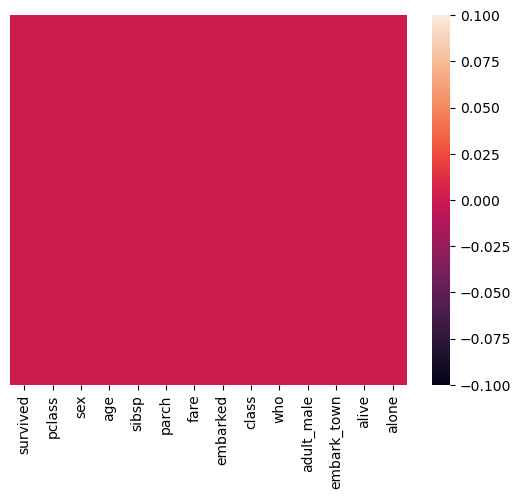

In [11]:
df = df.dropna()
sns.heatmap(df.isnull(), yticklabels=False)

### Adding or removing columns

We haven't done any EDA so it's not immediately obvious which columns we should keep. The only columns we would need to remove are columns that seem redundant. 

`embarked` and `embark_town` show the same information so we can remove one of them. Remove `embarked`. 

In [12]:
df = df.drop(['embarked'], axis=1)

### Encoding categorical variables
Use `factorize()` to recode features `sex`, `embark_town`(the harbor city), `survived` and into numerical data. This will *label encode* not *1-hot encode* the data. After you encode your data, replace the original columns with your encoded versions.

In [ ]:
# pandas functions pd.factorize() which outputs:
# An array of encoded labels (which you're assigning back to the column) 
# The array of unique original values (which you're discarding with _
# label encoding assigns a unqiue # to each variabel male: 1 female: 
    #df2 = df[["embark_town"]]
    #df2['sex'] = df['sex']
df['sex'], _ = pd.factorize(df['sex'])
df['embark_town'], _ = pd.factorize(df['embark_town'])

### Exploring the data
Now that we are done cleaning our data, let's explore.


We can make some quick plots with seaborn's `countplot(x=, data=)`. Create a count plot to show passager survival.

<AxesSubplot: xlabel='survived', ylabel='count'>

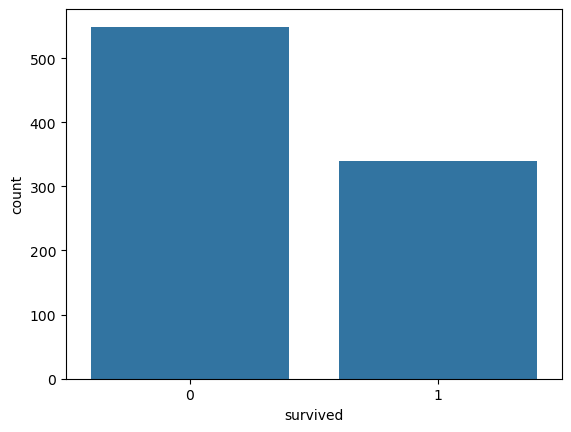

In [23]:
sns.countplot(x=df['survived'], data= df)

We can also break down survival by other categorical variables by adding the `hue=` parameter to `countplot()`. Set `hue` equal to the parameter you want to use tp split the plot. 


Create a plot of survival by sex.

<AxesSubplot: xlabel='survived', ylabel='count'>

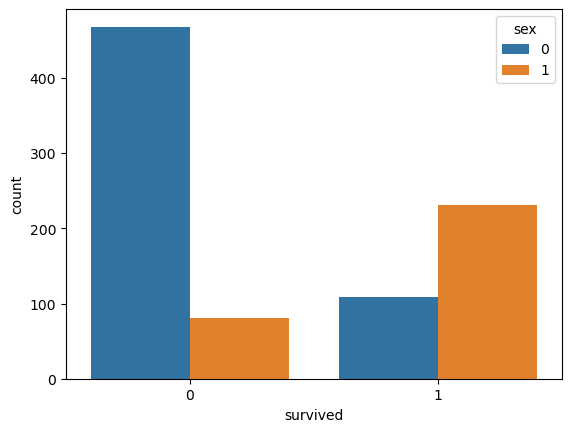

In [26]:
sns.countplot(x=df['survived'], data= df, hue='sex')

Create a plot of survival by passenger class.

<AxesSubplot: xlabel='survived', ylabel='count'>

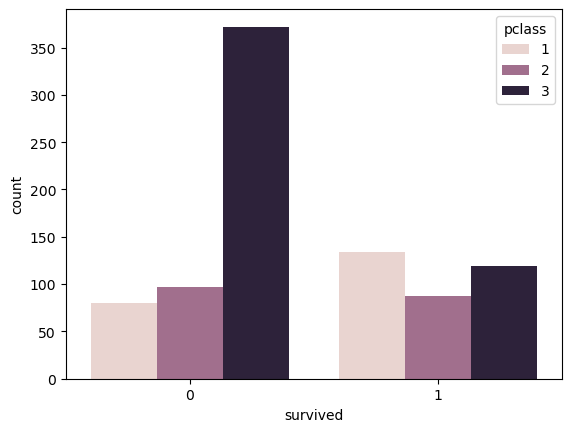

In [28]:
sns.countplot(x=df['survived'], data= df, hue='pclass')

Another way to look at survival by class is to use a distribution plot.

/tmp/ipykernel_141337/3116586558.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['survived'] == 0, 'pclass'], shade=True, color='m', label='Not Survived')
/tmp/ipykernel_141337/3116586558.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df['survived'] == 1, 'pclass'], shade=True, color='g', label='Survived')


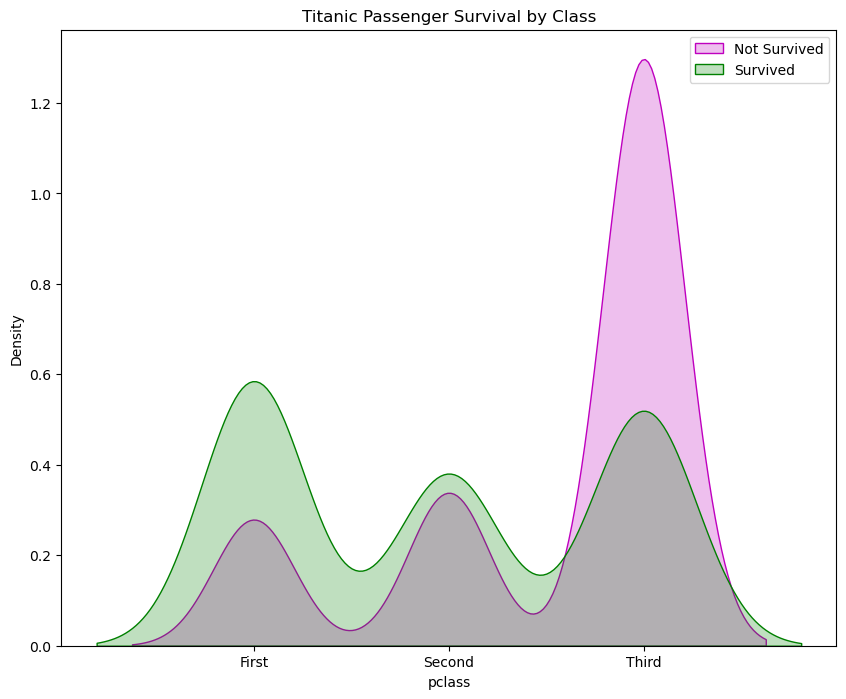

In [30]:
#Create the plot
fig, ax = plt.subplots(figsize=(10, 8))

#Plot KDE plot for not survived passengers
sns.kdeplot(df.loc[df['survived'] == 0, 'pclass'], shade=True, color='m', label='Not Survived')

#Plot KDE plot for survived passengers
sns.kdeplot(df.loc[df['survived'] == 1, 'pclass'], shade=True, color='g', label='Survived')

#Set labels for the x-axis
labels = ['First', 'Second', 'Third']
ax.set_xticks(sorted(df['pclass'].unique()))
ax.set_xticklabels(labels)

plt.title("Titanic Passenger Survival by Class")
plt.legend()
plt.show()

Looking at the graphs above, what groups are most likely to survive?


## Exploratory Data Analysis

Now that we have our dataset, we can start to extract features that help predict whether a passenger will survive. 

### Continuous Numerical Variables

To determine whether or not continuous numerical variables have a relationship, we can find the Pearson correlation coefficient.

For each continuous numerical variable, find the Pearson correlation coefficient and the p-value.

Assess the linear relationship for each of the variables. What conclusions can we come to according to the R value and the p-value?
- `age`: 
- `fare`: 

If a variable has a strong linear relationship with `survived`, create a linear regression and residuals plot for it.

### Discrete Categorical Variables

Even though `pclass`, `sex`, and `embark_town` are numerical after we encoded them, they are not continuous! We still need to treat them as discrete categorical variables in our analysis. 

For both columns, use ANOVA to compare the means of each group.

Analyze the results above. What conclusions can we come to according to the F-test score and the p-value?
- `pclass`: 
- `sex`: 
- `embark_town`: 

## K-NN classification with Scikit-Learn


### Split data into training and testing data

First we have to divide the DataFrame into 2 separated DataFrames:
  - `y` with the feature to be predicted (i.e. survived)
  - `x` with the other features that will be used for the model (all numeric features + sex recoded with factorize + embark_town recoded with factorize)

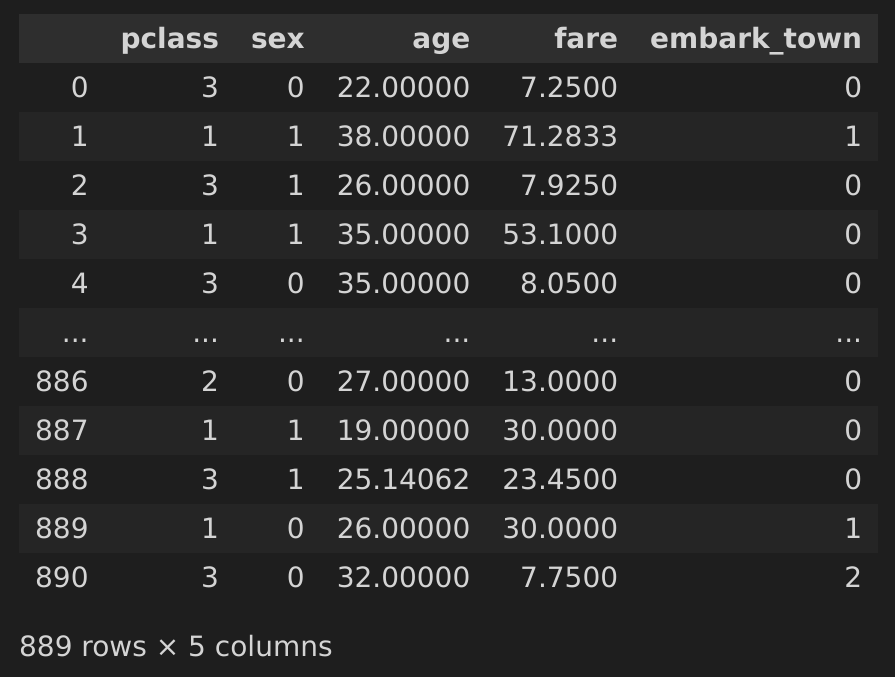

And then from `x` and `y`, we need to separate them for training and testing your model. 

We are going to use the function `train_test_split()` which returns 4 DataFrames:
- `x_train`: x training data
- `x_test`: x testing data
- `y_train`: y training data
- `y_train`: y testing data. 

We'll use it with 4 parameters: 
- `x`: model predictor set
- `y`: result set
- `train_size = 0.75`: 75% of data will be for training, the rest for testing
- `random_state = 55`: the randomness seed so we can compare answers

Print out the length of your initial dataset, the length of your training set, and the length of your testing set after spliting the data. Your training set should be 75% percent of your initial dataset. 

### Model initialization

Alright, it's time to create our model. This is going to follow a very similiar structure to our regression models.  

For that, create a model object `knn` that initializes your model with the `KNeighborsClassifier()` constructor. [More info here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

Just like linear regression we use the `fit()` function to fit the model. Fit the model to our training data.

### Model prediction

Let's test it! We are going to make a prediction. You can base this off yourself or make up a completely random passenger. 

Create 1 by 5 `numpy` array to represent your `pclass`, `sex`,`age`, `fare`, and `town`. Then use the `predict()` function on your `knn` model with your sample array. *If you want to get rid of the deprecation error, turn your array into a DataFrame with column name that match your training data.* 

### Model testing

Alright now that we tested it on a small scale, let's assess it's accuracy with our testing data. The first thing we can do, it look at the prediction probability for each result over all. Run the following code.

In [15]:
# for i, j in zip(knn.classes_, knn.predict_proba(x_test)[0]):
#   print("Prediction probability for:", i, "is", j)

You can compute the **accuracy score**(the number of correct predictions/total number of predictions)  directly with the `.score()` method. 

We can also use the `score()` method to evaluate both **underfitting** and **overfitting**. Compute the accuracy score of the training data. 

Looking at your accuracy scores, do you think your model is overfit, underfit, or neither? Remember the interpretations we talked about in class:

1. **High Training Score, Low Testing Score**: If your model has a high accuracy score on the training data but a significantly lower score on the testing data, it's likely overfitting.
2. **Similar Training and Testing Scores**: If both the training and testing scores are similar and relatively high, it suggests that your model is performing well and is likely not overfitting. 
3. **Low Training and Testing Scores**: If both the training and testing scores are low, it suggests that your model is underfitting.

Another way to assess our model is to use a **confusion matrix**. 

Create `conf_matrix` using the function `confusion_matrix(y_true=, y_pred=)`. Your true y values will be your `y_test` matrix from above and your y hat values will be the result of running the `knn` prediction on `x_test`. 

In [16]:
# # run the following code to print your confusion matrix
# class_labels = [str(label) for label in knn.classes_]
# confusion_df = pd.DataFrame(data=conf_matrix,
#                             index=[label + " ACTUAL" for label in class_labels],
#                             columns=[label + " PREDICTED" for label in class_labels])

# print(confusion_df)

How many false positives are there?  In other words, how many people were predicted to die when in fact they survived?

How many false negatives are there? In other words, how many people were predicted to survive when in fact they died?

To evaluate the **precison** and **recall** of our model, we will calculate it's **F-score**. You can calculate an F1 score with the formula:

$$F1 = \frac{2 * TP}{2*TP + FP + FN}$$

or with the `sklearn` function `f1_score(y, y_hat)`. Import this method with `from sklearn.metrics import f1_score`.

How do you feel about our model so far? Do we think it accuratly describes the variability in our data or not? 

*Accuracy scores and confusion matricies are not the only ways to assess classification models, but are the two we are going to use in this notebook.*

## Improving our model 

There are multiple different strategies we can try to improve our model. We can make adjustments to the model itself and/or make adjustments to our data. 

### Hyperparmeters

If we want to adjust how the machine learning algorithm is creating our model, we can adjust its **hyperparameters**. In this case, let's play with the `n_neighbors` and `weights` hyperparameters of the model.  

**n_neighbors**

The `n_neighbors` hyperparameter sets the number of neighbors to consider when making predictions for a new data point. By default, `KNeighborsClassifer` uses a value of 5. 
- A smaller `n_neighbors` tends to result in a more complex decision boundary and could caputre complexities in intricate data more effectively. However, it does make the model more sensitive to noise in the training data and could result in overfitting.
- A larger `n_neighbors` tends to result in a more simple decision boundary, but can lead to underfitting by oversimplifying the model. 

Let's see how changing `n_neighbors` changes our model. Create a `knn` models for `n_neighbors` = 2 through 10 and print out their training and testing scores.

**weights**

The `weights` hyperparameter determines how the neighbors' contributions are weighted when making predictions. There are two options for `weights`:
- `"uniform"`: All neighbors are weighted equally
- `"distance"`: Closer neighbors have more influence on the prediction than farther neighbors

By default, `weights` is set to `"uniform"`. Run the same experiment as above, this time with `"distance"`. 

Putting it altogether, which combination of `n_neighbors` and `weights` gives the most accurate model?

Create a confusion matrix for the most accurate model.

Calculate the F-score of the most accurate model.

Intepret the results: